# 隐马可夫模型 (Hidden Markov Model)

隐马可夫模型（HMM）是一个针对序列的生成式模型（Generative Model）。常见的序列是书上的一个句子或者说出的一句话。比如在给出一串语音的时候，希望计算机可以推断出究竟说的是哪些词，这个场景就可以用隐马模型建模。

语音识别首先面对的问题就是怎么处理发音的差异。比如，让不同的人读 “philosophy” 这个词，男女老少读出来的是不一样的语音序列。人们可以轻松的识别出 “philosopy” 就说明每个词在统计意义上是有其特征的。隐马模型就可以用来寻找这个特征，从而识别语音。

隐马模型中区分观察到的状态和隐藏的状态。上面的例子中，不同人的发音就是观察到的状态，对应 “philosopy” 的特征就是隐藏状态。上面所谓的“生成式模型”可以理解成，每个认识 “philosophy” 的人都知道它的发音特征，基于这个认识调动喉部肌肉“产生出”发声。所以“生成式”强调“从隐藏状态产生观察状态”的过程。

单词的发音显然是一个时序过程，单词的发音特征就可以用时序模型建模。马可夫过程是一个简单时序模型，强调给定当前状态就可以推断出下个状态的概率分布，历史状态不会提供额外的信息。在语义识别上这当然是个很不实际的假设，但是在声音的浅层识别（比如音频到音素识别）上还是有效的，所以单词的发音特征序列就可以用马可夫链来建模。

下面看看模型的具体定义。

## HMM 模型定义

隐马模型的概率图是这个样子的（图来自 Hulu 机器学习第二十六讲）：

<img src="hmm-graph.png">

隐藏状态序列（$x_i$）形成一个马可夫链，观察状态（$y_i$）依据每个节点上隐藏状态所对应的概率分布随机产生。

准确定义这个模型需要下面三个参数：

1. $p(x_1)$，初始隐藏状态的概率分布
1. $p(x_{i+1} \mid x_i)$，隐藏状态之间的转换概率
1. $p(y_i \mid x_i)$，从隐藏状态到观察状态的概率分布

假设有 $K$ 种隐藏状态，有 $D$ 种观察状态，在离散的情况下，$p(x_1)$ 是 $K$ 个元素的数组；$p(x_{i+1} \mid x_i)$ 是 $K \times K$ 的矩阵；$p(y_i \mid x_i)$ 是 $K \times D$ 的矩阵。

训练（学习）一个 HMM 模型既是寻找这三个参数的过程。比如可以为每个单词训练一个 HMM，各自有对应的参数。有了多个模型之后，针对给定的一个单词的读音，可以计算哪个模型产生这个读音的概率最大（即模型评估），从而识别单词。

在分词的场景中，可以用一个训练好的模型去分解一个句子，寻找最可能的拆分方案。拆分方案就是隐藏状态，寻找最优方案的过程可以认为是寻找最优编码。

应用 HMM 是主要面对的就是上面提到的三个问题：训练，模型评估，解码。下面用掷色子的例子介绍一下面对三个问题时使用的算法。语音识别和分词的问题以后会继续。

## 掷色子

这个例子取自 [Hidden Markov Models - the Unfair Casino](http://web.stanford.edu/class/stats366/hmmR2.html).

这里有两个色子，一个是正常的（即六个面是等概率的），另一个做了手脚，使 6 出现的概率为 0.5，其余 5 个面出现的概率都是 0.1。如果每次随机选取一个色子，然后抛出它将得到一个数字，重复多次可以得到一个数字序列。

假设对选择色子的随机过程做如下限制：
1. 开始时的色子根据一个概率 $p(x_1)$ 分布选择
1. 后续色子是根据一个马可夫链状态转换矩阵 $p(x_{i+1} \mid x_i)$ 中的概率来选择

，然后抛掷被选的色子得到数字序列，那整个过程将可以用 HMM 建模。


下面看一下解码的问题，即在知道 $p(x_1), p(x_{i+1} \mid x_i), p(y_i \mid x_i)$ 的情况下，对给定的 $Y = (y_1, y_2, \dots, y_n)$ 序列，如何求出最可能的 $X = (x_1, x_2, \dots, x_n)$ 序列。具体到这个问题就是，看到了一串数字，想知道它们都是哪个色子掷出的。

### 解码



首先定义 HMM 参数（完整的实现在 [HMM-import.ipynb](HMM-import.ipynb) 里）。

In [8]:
%%capture
%run HMM-import.ipynb
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] =[12,9]

In [3]:
# 选择第一个色子时的概率
pi = np.array([0.5, 0.5])
# 两个色子的状态转换矩阵
transp = np.array([[0.99, 0.01], [0.02, 0.98]])
# 两个色子各自的投掷概率
emissp = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6], [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]])

下面根据这些参数执行模拟过程，产生出观测数字序列。

In [4]:
def simulate(N):
    hs = []
    xs = []
    ht = np.random.choice([0,1], p=pi)
    hs.append(ht)
    for _ in range(N-1):
        ht = np.random.choice([0, 1],p=transp[ht, :])
        hs.append(ht)
    for h in hs:
        xt = np.random.choice(range(6), p=emissp[h, :])
        xs.append(xt)
    return hs, xs

In [10]:
hs, vs = simulate(800)

hs 是隐藏状态序列，即每一步是哪个色子被投掷。vs 是观察到的数字序列。


下面看如何根据观察序列推断出最可能的隐藏序列。这个问题用公式表达出来就是 $max_{X}\log{p(X \mid Y)}$。因为 $p(X \mid Y) = \frac{p(X, Y)}{p(Y)}$，而分母 $p(Y)$ 是跟 $X$ 无关的量，所以上面的最大化可以用 $max_{X}\log{p(X, Y)}$ 代替。

因为 $p(X, Y) = p(x_1)\prod_{n=1}^{N}p(y_n \mid x_n)\prod_{m=2}^{N}p(x_m \mid x_{m-1})$，最大化的表达式为：

$$
max_{X}\log{p(x_1)} + \sum_{n=1}^{N}{\log{p(y_n \mid x_n)}} + \sum_{m=2}^{N}{\log{p(x_m \mid x_{m-1})}}.
$$

这个最大化本质是尝试所有 $X$ 的可能组合，找到值最大的一组。但由于变量之间有限的相关性（$x_m$ 只与 $x_{m-1}$ 相关），尝试所有组合将引发大量重复的计算。这个问题可以用 max-sum 算法解决。max-sum 算法是一个通用的，利用条件无关性（conditional-independence）来解决重复计算问题的算法框架。具体到 HMM 上就是称为 Viterbi 的算法（Andrew Viterbi 1967年提出）。max-sum 和 viterbi 都属于动态规划算法，背后的基础都是条件无关性，以后会专门说说动态规划。下面简单看一下如何得出 viterbi 算法。

上面最大化表达式是关于 $(x_1, x_2, \dots, x_N)$ 的函数，与 $Y$ 无关，展开后表示为：

$$
max_{X}\log{p(x_1)} + \log{p(y_1 \mid x_1)} + \log{p(x_2 \mid x_{1})} + \log{p(y_2 \mid x_2)} + \log{p(x_3 \mid x_{2})} + \log{p(y_3 \mid x_3)} + \cdots + \log{p(x_N \mid x_{N-1})} + \log{p(y_N \mid x_N)}.
$$

如果设：
\begin{align}
f_1(x_1, x_2) & = \log{p(x_1)} + \log{p(y_1 \mid x_1)} + \log{p(x_2 \mid x_{1})} + \log{p(y_2 \mid x_2)}\\
f_2(x_2, x_3) & = \log{p(x_3 \mid x_{2})} + \log{p(y_3 \mid x_3)}\\
f_{n-1}(x_{n-1}, x_n) & = \log{p(x_n \mid x_{n-1})} + \log{p(y_n \mid x_n)}
\end{align}
，最大化表达式可以表示为：

$$
max_{x_1,x_2,\dots,x_n} f_1(x_1,x_2) + f_2(x_2, x_3) + f_3(x_3, x_4) + \dots + f_{n-1}(x_{n-1}, x_n).
$$

为了避免重复计算，首先注意到 $x_1$ 的变动只影响 $f_1$ 的值。如果定义：
$$
h_1(x_2) = max_{x_1}f_1(x_1,x_2)
$$
，就可以简化最大化表达式为：
$$
max_{x_2,\dots,x_n} h_1(x_2) + f_2(x_2, x_3) + f_3(x_3, x_4) + \dots + f_{n-1}(x_{n-1}, x_n).
$$

$h_1(x_2)$ 这个函数是 $x_2$ 到 $f_1(*, x_2)$ 极值的映射，$*$ 号代表尝试所有的 $x_1$。另外注意一下，最大化表达式的下标中已经去掉了 $x_1$。只所以能做这个简化就是因为 $x_1$ 的变动只影响 $f_1$ 的值，不影响其他 $f_i$ 的值。或者说 $x_1$ 对最大值的影响已经完全包含在了 $h_1$ 这个函数里。

相应的，$x_2$ 的变动只影响到 $h_1$ 和 $f_2$，可以继续定义：
$$
h_2(x_3) = max_{x_2}h_1(x_2) + f_2(x_2, x_3)
$$
，最大化表达式进一步简化为：
$$
max_{x_3,\dots,x_n} h_2(x_3) + f_3(x_3, x_4) + \dots + f_{n-1}(x_{n-1}, x_n).
$$

这次减掉了 $x_2$。$h_i$ 函数的下标可以认为是减掉的第几个 $x$ 变量。

这个过程继续下去，最后可以简化为：
$$
max_{x_n} h_{n-1}(x_n).
$$
其中
$$
h_{n-1}(x_n) = max_{x_{n-1}}h_{n-2}(x_{n-1}) + f_{n-1}(x_{n-1}, x_n).
$$

实际的计算过程就是逐次计算 $h_i$ 的过程，最后的极值由 $max_{x_n} h_{n-1}(x_n)$ 得出。

那如何得知是哪一组 $X$ 取得了最大值呢？

由最后一步可以知道是从哪个 $x_n$ 取得了最大值，记为 $x_n^{max} = argmax_{x_n} h_{n-1}(x_n)$。有了 $x_n^{max}$ 就可以回填到 $h_{n-1}$ 的表达式，找到 $x_{n-1}^{max}$：$x_{n-1}^{max} = argmax_{x_{n-1}}h_{n-2}(x_{n-1}) + f_{n-1}(x_{n-1}, x_n^{max})$。这个过程可以一直回溯到 $x_1^{max}$，这样就找到了最可能的一组 $X$。这个过程叫 back-tracing。

下面是 HMM viterbi 算法的实现：

In [6]:
def HMMViterbi(v):
    N = len(v)
    trace = np.zeros((N, 2))
    trace[0, :] = np.log(pi) + np.log(emissp[:, v[0]])
    traj = np.ones((N, 2)) * -1
    for i in range(1, N):
        s = np.log(transp.T) + np.log(emissp[:, v[i]]) + trace[i-1,:]
        trace[i,:] = np.max(s.T, axis=0)
        traj[i, :] = np.argmax(s.T, axis=0)
    hs = []
    last = np.argmax(trace[N-1,:])
    hs.append(last)
    for i in range(N-1, 0, -1):
        last = int(traj[i, last])
        hs.append(last)
    return list(reversed(hs))

下面看一下效果。比较一下真实的色子状态和推测出的最可能色子状态。

<Container object of 800 artists>

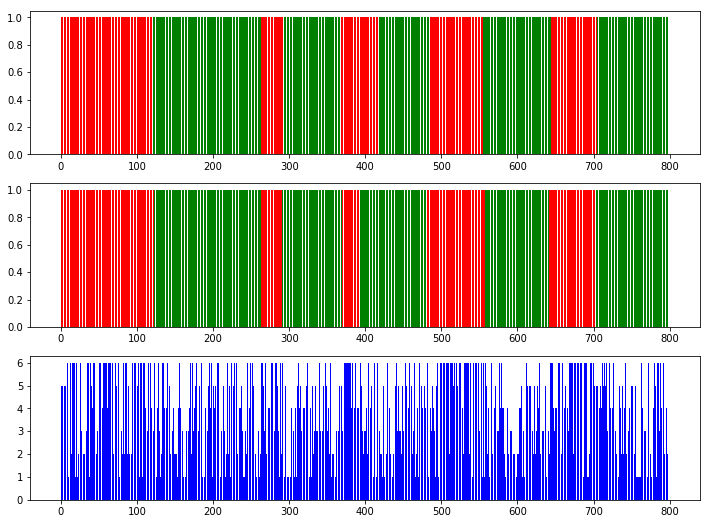

In [11]:
phs = HMMViterbi(vs)

#vs, hs, phs

hscolor = ['green' if h == 0 else 'red' for h in hs]

phscolor = ['green' if h == 0 else 'red' for h in phs]

fig, ax = plt.subplots(3, 1)
ax[0].bar(range(len(hs)), 1, color=hscolor)
ax[1].bar(range(len(hs)), 1, color=phscolor)
ax[2].bar(range(len(hs)), np.array(vs)+1,color='blue')

上面第一行是真实的色子状态，第二行是推测出的最可能的色子状态，红色代表作了手脚的色子，绿色代表正常的色子。第三行是色子掷出的数字。

可以看到推测出的隐藏状态接近真实的隐藏状态。

### 训练参数

上面展示了在知道 HMM 参数的情况下，从观察序列推测隐藏序列的过程。那 HMM 的参数如何训练呢？

如果知道观察序列并且知道隐藏序列，HMM 的参数训练比较简单。通过简单的计数就可以得到隐藏状态的转换矩阵和从隐藏状态到观察状态的概率分布。如果只知道观察序列不知道隐藏序列，可以用期望最大化（Expectation-Maximization，EM）算法来训练。

期望最大化算法通过循环交替下面两步来求解（假设所有的参数都包含在 $\theta$ 里）：
1. 在现有 $\theta^{old}$ 的条件下，估计隐藏状态的概率分布
1. 在现有隐藏状态的估计下，寻找最优的模型参数 $\theta^{new}$。

循环的过程会持续的改进模型产生观察序列的概率，即 $p(X \mid \theta)$。当改进停止或者改进幅度非常小的时候可以终止循环。要启动循环需要初始化模型参数，最好可以利用一些先验知识，没有的话就随机初始化参数 $\theta^{init}$。由于 EM 算法很容易收敛于局部最优解，可以运行多次 EM 算法（得到多个不同的初始参数 $\theta^{init}$），以增加得到全局最优解的机会。

HMM 的 EM 算法推导过程会另写一篇，下面看一下效果。

先定义辅助函数：

In [14]:
def HMMforward(v, N, K, pi_, emissp_, transp_):
    logalpha = np.ones((N, K)) * -np.inf
    logalpha[0, :] = np.log(pi_) + np.log(emissp_[:, v[0]])
    for i in range(1, N):
        logalpha[i, :] = np.log(emissp_[:, v[i]]) + logsumexp(logalpha[i-1, :] + np.log(transp_.T), axis=1)
    return logalpha, logsumexp(logalpha[N-1,:])

def HMMbackward(v, N, K, emissp_, transp_):
    logbeta = np.ones((N, K)) * -np.inf
    logbeta[N-1, :] = np.zeros(K)
    for i in range(N-2, -1, -1):
        logbeta[i, :] = logsumexp(logbeta[i+1, :] + np.log(emissp_[:, v[i+1]]) + np.log(transp_), axis=1)
    return logbeta

def HMMsmooth(logalpha, logbeta, v, N, K, emissp_, transp_):
    r = np.zeros((N, K))
    for i in range(N):
        r[i, :] = logalpha[i, :] + logbeta[i, :]
    r = condexp(r)
    A = np.zeros((K, K, N))
    for i in range(1, N):
        A[:, :, i] = np.matlib.repmat(logalpha[i-1, :].reshape(-1,1), 1, 2) + logbeta[i, :] + np.log(emissp_[:, v[i]]) + np.log(transp_[:, :])
        logmax = np.max(A[:, :, i])
        A[:, :, i] -= logmax
        A[:, :, i] = np.exp(A[:, :, i])
        A[:, :, i] = A[:, :, i] / np.sum(A[:, :, i])
    return r, A

再定义 EM 函数。

In [15]:
def HMMem(V, N, K, D, niters):
    ph1 = condp(np.random.rand(K)) # pi
    phthtp = condp(np.random.rand(K, K)) # transp
    pvtht = condp(np.random.rand(K, D)) # emissp
    times = 0
    lastllik = -np.inf
    for i in range(niters):
        a = np.zeros(K)
        A = np.zeros((K, K))
        B = np.zeros((K, D))
        llik = 0
        for m in range(len(V)):
            v = V[m]
            # E-step
            logalpha, llik_ = HMMforward(v, N, K, ph1, pvtht, phthtp)
            logbeta = HMMbackward(v, N, K, pvtht, phthtp)
            r, A_ = HMMsmooth(logalpha, logbeta, v, N, K, pvtht, phthtp)
            llik += llik_
            # collect
            a += r[0, :]
            A += np.sum(A_, axis=2)
            for j in range(N):
                B[:, v[j]] += r[j, :]
        # M-step
        ph1 = condp(a)
        phthtp = condp(A)
        pvtht = condp(B)
        llik /= len(V)
        if llik - lastllik < 0.003:
            times += 1
        else:
            times = 0
        if times >= 5:
            break
        lastllik = llik
    return ph1, phthtp, pvtht, llik


上面 EM 的循环过程中会监控 $ log{p(X \mid \theta)}$ 的值，如果连续五次改进的幅度都小于 0.003，则退出循环。

下面是准备观察序列。

In [16]:
M = 100
N = 800
vs = np.zeros((M, N), dtype=int)
for m in range(M):
    _, v = simulate(N)
    vs[m, :] = np.array(v, dtype=int)


最后是针对观察序列多次运行 EM 算法，选择最好的一组参数。

In [18]:
best = -np.inf
best_pi = best_transp = best_emissp = None
for _ in range(10):
    ph1, phthtp, pvtht, llik = HMMem(vs, len(vs), 2, 6, 2000)
    print("-- log likelihood: {}".format(llik))
    if llik > best:
        best = llik
        best_pi = ph1
        best_transp = phthtp
        best_emissp = pvtht
        
print("ph1: {}".format(best_pi))
print("phthtp: {}".format(best_transp))
print("pvtht: {}".format(best_emissp))
print("---- log likelihood: {}".format(best))


-- log likelihood: -170.0522129428408
-- log likelihood: -173.4702767794389
-- log likelihood: -170.05213799456536
-- log likelihood: -173.46696749908853
-- log likelihood: -173.40749679044217
-- log likelihood: -170.05220115652392
-- log likelihood: -170.052135100445
-- log likelihood: -173.48174276900747
-- log likelihood: -173.47633736243083
-- log likelihood: -170.05224237070328
ph1: [ 0.45943569  0.54056431]
phthtp: [[ 0.99042401  0.00957599]
 [ 0.01548558  0.98451442]]
pvtht: [[ 0.16195163  0.17027217  0.16431041  0.17508062  0.16408556  0.16429962]
 [ 0.10166069  0.10692512  0.10226344  0.09967972  0.10302182  0.48644921]]
---- log likelihood: -170.052135100445


可以看到训练出来的参数与实际的参数是接近的。

### 模型评估

上面参数训练的过程就包含模型评估，也是提升模型与观察数据匹配度的过程。HMM 的模型评估由“前向”算法（forward）得出，即上面的 HMMforward 函数。

模型评估本质上是求解 $p(Y) = \sum_{X}p(Y, X)$，即对所有可能的 $X$ 组合计算 $p(Y, X)$ 的和。前向算法利用变量之间的条件无关性避免了大量的重复计算，从而提高了效率。具体的推导过程会跟 EM 算法的推导过程一起给出。

## 小结

这里主要借助掷色子的小例子讨论了与 HMM 相关的算法实现，显示了 HMM 的能力。以后会再介绍它在自然语言处理上的应用。

HMM 是概率图模型的一个应用，所涉及的算法基本是概率图模型算法的特例。后续讨论概率图模型时会再来与 HMM 联系。

上面省略的 EM 算法的推导过程会在下一篇中介绍。